# 💿 Spotify Tracks
## 🎵 Hypothesis 4 — Clustering & Popularity Differences

| Field         | Description |
|---------------|-------------|
| Author:       | Group |
| Course:       | Code Institute – Data Analytics with AI Bootcamp |
| Project Type: |	Hackathon 2 |
| Date:         |	December 2025 |

$$
\begin{aligned}
H_{0} &= \text{There are no statistically significant differences in popularity between the identified music clusters.} \\
H_{1} &= \text{Tracks cluster into distinct musical profiles that differ significantly in popularity.}
\end{aligned}
$$

### Import Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from kneed import KneeLocator
import warnings
warnings.filterwarnings("ignore")

### Project Paths

In [2]:
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data" / "clean"
IMAGE_DIR = PROJECT_ROOT / "figures"
if not IMAGE_DIR.exists():
    IMAGE_DIR.mkdir(parents=True)
MODELS_OUTPUT_PATH = PROJECT_ROOT / "model_outputs"
if not MODELS_OUTPUT_PATH.exists():
    MODELS_OUTPUT_PATH.mkdir(parents=True)
INPUT_CSV = DATA_DIR / "spotify_clean.csv"

### Load Custom Libraries

In [3]:
from utils.data_processing import load_data
from utils.feature_engineering import add_interaction_terms
from utils.visualisation import plot_scatter

### Load Dataset

In [4]:
df = load_data(INPUT_CSV)
df.head()

,artists,name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,artist_primary
0,sam smith;kim petras,unholy,100,156943,False,0.714,0.472,2,-7.375,1,0.0864,0.01300,0.000005,0.2660,0.238,131.121,4,pop,sam smith
1,bizarrap;quevedo,"quevedo: bzrp music sessions, vol. 52",99,198937,False,0.621,0.782,2,-5.548,1,0.0440,0.01250,0.033000,0.2300,0.550,128.033,4,hip-hop,bizarrap
2,manuel turizo,la bachata,98,162637,False,0.835,0.679,7,-5.329,0,0.0364,0.58300,0.000002,0.2180,0.850,124.980,4,reggaeton,manuel turizo
3,david guetta;bebe rexha,i'm good,98,175238,True,0.561,0.965,7,-3.673,0,0.0343,0.00383,0.000007,0.3710,0.304,128.040,4,edm,david guetta
4,bad bunny;chencho corleone,me porto bonito,97,178567,True,0.911,0.712,1,-5.105,0,0.0817,0.09010,0.000027,0.0933,0.425,92.005,4,reggae,bad bunny


### Add Features

In [5]:
df_cluster = add_interaction_terms(df)
df.head()

,artists,name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,time_signature,genre,artist_primary,danceability_energy_index,acoustic_profile,mood_index,vocal_presence
0,sam smith;kim petras,unholy,100,156943,False,0.714,0.472,2,-7.375,1,...,0.2660,0.238,131.121,4,pop,sam smith,0.168504,2.931500e-08,0.056168,0.999995
1,bizarrap;quevedo,"quevedo: bzrp music sessions, vol. 52",99,198937,False,0.621,0.782,2,-5.548,1,...,0.2300,0.550,128.033,4,hip-hop,bizarrap,0.242811,2.062500e-04,0.215050,0.967000
2,manuel turizo,la bachata,98,162637,False,0.835,0.679,7,-5.329,0,...,0.2180,0.850,124.980,4,reggaeton,manuel turizo,0.283483,5.771700e-07,0.288575,0.999998
3,david guetta;bebe rexha,i'm good,98,175238,True,0.561,0.965,7,-3.673,0,...,0.3710,0.304,128.040,4,edm,david guetta,0.270682,1.353905e-08,0.146680,0.999993
4,bad bunny;chencho corleone,me porto bonito,97,178567,True,0.911,0.712,1,-5.105,0,...,0.0933,0.425,92.005,4,reggae,bad bunny,0.324316,1.207340e-06,0.151300,0.999973


In [6]:
feature_columns = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'danceability_energy_index', 'acoustic_profile', 'mood_index', 'vocal_presence' 
]

df_features = df_cluster[feature_columns]
df_features.shape

(77508, 13)

In [7]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

Optimal number of clusters: 5


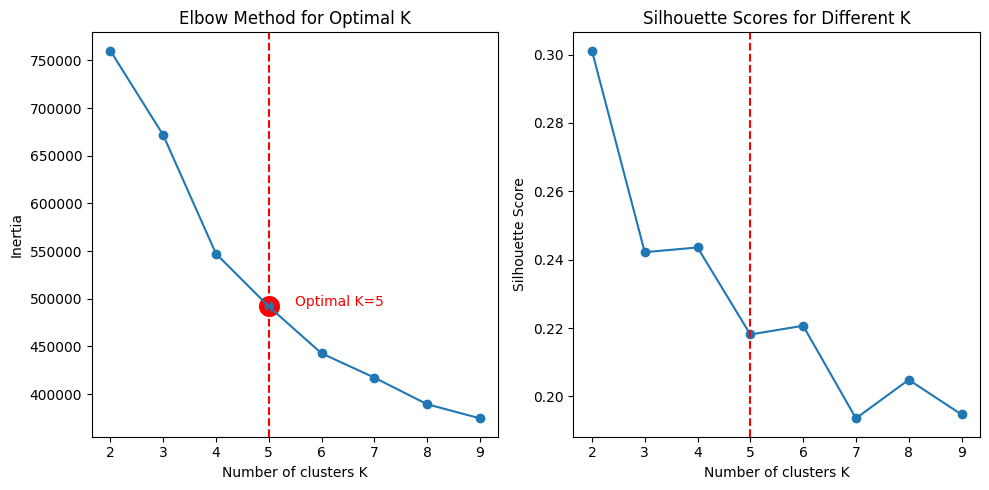

In [8]:
intertia = []
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    intertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, kmeans.labels_))

kl = KneeLocator(K_range, intertia, curve="convex", direction="decreasing")
optimal_k = kl.elbow
print(f"Optimal number of clusters: {optimal_k}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, intertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')

if optimal_k:
    elbow_y = intertia[K_range.index(optimal_k)]
    plt.scatter(optimal_k, elbow_y, s=200, c='red', label='Elbow Point')
    plt.axvline(x=optimal_k, linestyle='--', color='red')
    plt.text(optimal_k + 0.5, elbow_y + 1000, f'Optimal K={optimal_k}', color='red')

plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, marker='o')
plt.title('Silhouette Scores for Different K')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')

if optimal_k:
    plt.axvline(x=optimal_k, linestyle='--', color='red')

plt.tight_layout()
plt.savefig(f"{IMAGE_DIR}/kmeans_elbow_silhouette.png")
plt.show()

In [9]:
kmean = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmean.fit_predict(df_scaled)

df_clustered = df_features.loc[df_features.index].copy()
df_clustered['cluster'] = cluster_labels
df_clustered['cluster'] = df_clustered['cluster'].astype('category')
df_clustered.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability_energy_index,acoustic_profile,mood_index,vocal_presence,cluster
0,0.714,0.472,-7.375,0.0864,0.01300,0.000005,0.2660,0.238,131.121,0.168504,2.931500e-08,0.056168,0.999995,4
1,0.621,0.782,-5.548,0.0440,0.01250,0.033000,0.2300,0.550,128.033,0.242811,2.062500e-04,0.215050,0.967000,2
2,0.835,0.679,-5.329,0.0364,0.58300,0.000002,0.2180,0.850,124.980,0.283483,5.771700e-07,0.288575,0.999998,2
3,0.561,0.965,-3.673,0.0343,0.00383,0.000007,0.3710,0.304,128.040,0.270682,1.353905e-08,0.146680,0.999993,4
4,0.911,0.712,-5.105,0.0817,0.09010,0.000027,0.0933,0.425,92.005,0.324316,1.207340e-06,0.151300,0.999973,2


In [10]:
cluster_summary = (
    df_clustered
    .groupby('cluster', observed=True)[feature_columns]
    .mean()
    .round(3)
    .reset_index()
)

cluster_summary

,cluster,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability_energy_index,acoustic_profile,mood_index,vocal_presence
0,0,0.523,0.368,-11.094,0.062,0.656,0.024,0.181,0.384,113.128,0.098,0.007,0.073,0.976
1,1,0.566,0.758,-8.347,0.074,0.091,0.787,0.194,0.339,127.388,0.208,0.036,0.126,0.213
2,2,0.676,0.763,-6.181,0.091,0.225,0.022,0.211,0.736,123.403,0.255,0.001,0.280,0.978
3,3,0.379,0.206,-20.107,0.054,0.859,0.857,0.166,0.211,105.141,0.042,0.368,0.024,0.143
4,4,0.499,0.781,-5.979,0.131,0.133,0.028,0.289,0.342,130.948,0.190,0.001,0.132,0.972


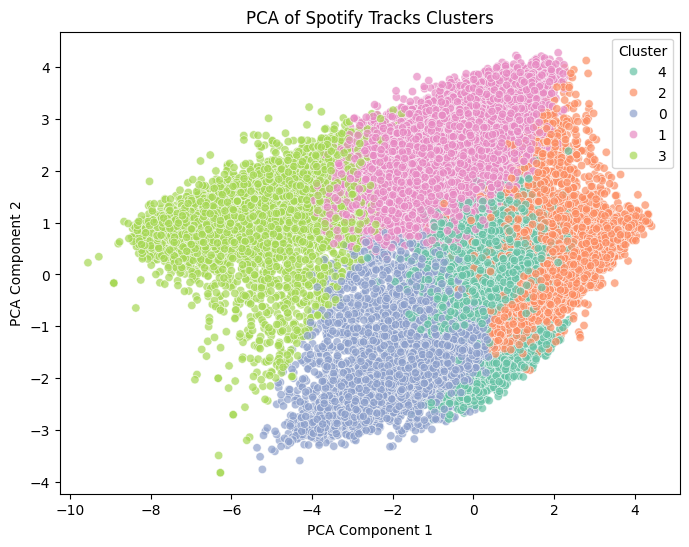

In [11]:
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=df_clustered['cluster'].astype(str),
    palette='Set2',
    alpha=0.7
)
plt.title('PCA of Spotify Tracks Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.savefig(f"{IMAGE_DIR}/kmeans_pca_clusters.png")
plt.show()

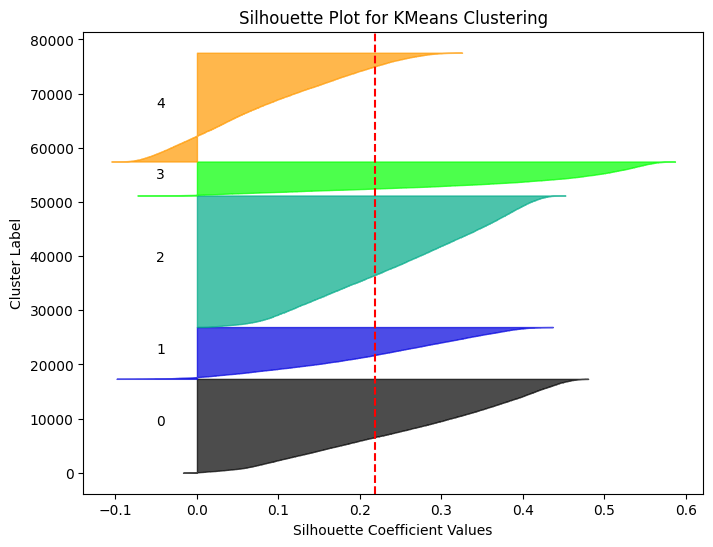

In [12]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels_final = kmeans_final.fit_predict(df_scaled)
silhouette_vals = silhouette_samples(df_scaled, cluster_labels_final)

y_lower = 10
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    ith_cluster_silhouette_values = silhouette_vals[cluster_labels_final == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10
plt.title("Silhouette Plot for KMeans Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--")
plt.savefig(f"{IMAGE_DIR}/kmeans_silhouette_plot.png")
plt.show()

In [13]:
df.head()

,artists,name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,time_signature,genre,artist_primary,danceability_energy_index,acoustic_profile,mood_index,vocal_presence
0,sam smith;kim petras,unholy,100,156943,False,0.714,0.472,2,-7.375,1,...,0.2660,0.238,131.121,4,pop,sam smith,0.168504,2.931500e-08,0.056168,0.999995
1,bizarrap;quevedo,"quevedo: bzrp music sessions, vol. 52",99,198937,False,0.621,0.782,2,-5.548,1,...,0.2300,0.550,128.033,4,hip-hop,bizarrap,0.242811,2.062500e-04,0.215050,0.967000
2,manuel turizo,la bachata,98,162637,False,0.835,0.679,7,-5.329,0,...,0.2180,0.850,124.980,4,reggaeton,manuel turizo,0.283483,5.771700e-07,0.288575,0.999998
3,david guetta;bebe rexha,i'm good,98,175238,True,0.561,0.965,7,-3.673,0,...,0.3710,0.304,128.040,4,edm,david guetta,0.270682,1.353905e-08,0.146680,0.999993
4,bad bunny;chencho corleone,me porto bonito,97,178567,True,0.911,0.712,1,-5.105,0,...,0.0933,0.425,92.005,4,reggae,bad bunny,0.324316,1.207340e-06,0.151300,0.999973


In [14]:
df_features.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability_energy_index,acoustic_profile,mood_index,vocal_presence
0,0.714,0.472,-7.375,0.0864,0.01300,0.000005,0.2660,0.238,131.121,0.168504,2.931500e-08,0.056168,0.999995
1,0.621,0.782,-5.548,0.0440,0.01250,0.033000,0.2300,0.550,128.033,0.242811,2.062500e-04,0.215050,0.967000
2,0.835,0.679,-5.329,0.0364,0.58300,0.000002,0.2180,0.850,124.980,0.283483,5.771700e-07,0.288575,0.999998
3,0.561,0.965,-3.673,0.0343,0.00383,0.000007,0.3710,0.304,128.040,0.270682,1.353905e-08,0.146680,0.999993
4,0.911,0.712,-5.105,0.0817,0.09010,0.000027,0.0933,0.425,92.005,0.324316,1.207340e-06,0.151300,0.999973


In [15]:
df_merged = df_clustered.merge(
    df[['name', 'artists', 'popularity']],
    left_index=True,
    right_index=True
)
df_merged.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability_energy_index,acoustic_profile,mood_index,vocal_presence,cluster,name,artists,popularity
0,0.714,0.472,-7.375,0.0864,0.01300,0.000005,0.2660,0.238,131.121,0.168504,2.931500e-08,0.056168,0.999995,4,unholy,sam smith;kim petras,100
1,0.621,0.782,-5.548,0.0440,0.01250,0.033000,0.2300,0.550,128.033,0.242811,2.062500e-04,0.215050,0.967000,2,"quevedo: bzrp music sessions, vol. 52",bizarrap;quevedo,99
2,0.835,0.679,-5.329,0.0364,0.58300,0.000002,0.2180,0.850,124.980,0.283483,5.771700e-07,0.288575,0.999998,2,la bachata,manuel turizo,98
3,0.561,0.965,-3.673,0.0343,0.00383,0.000007,0.3710,0.304,128.040,0.270682,1.353905e-08,0.146680,0.999993,4,i'm good,david guetta;bebe rexha,98
4,0.911,0.712,-5.105,0.0817,0.09010,0.000027,0.0933,0.425,92.005,0.324316,1.207340e-06,0.151300,0.999973,2,me porto bonito,bad bunny;chencho corleone,97


In [16]:
overview_stats = df_merged.groupby('cluster')['popularity'].describe()
overview_stats


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,17327.0,35.968604,19.715527,0.0,22.0,37.0,51.0,96.0
1,9559.0,27.464379,17.355959,0.0,14.0,22.0,42.0,86.0
2,24274.0,37.336574,19.370542,0.0,24.0,37.0,50.0,99.0
3,6264.0,30.675766,19.497555,0.0,18.0,28.0,48.0,86.0
4,20084.0,37.772904,18.582779,0.0,23.0,38.0,52.0,100.0


In [17]:
pg.normality(df_merged, dv='popularity', group='cluster', alpha=0.05)

,W,pval,normal
cluster,,,
4,0.984818,3.691081e-41,False
2,0.986896,1.296099e-41,False
0,0.978613,1.872597e-44,False
1,0.954351,2.426081e-47,False
3,0.958650,6.553389e-39,False


In [18]:
pop_summary = (
    df_merged.groupby("cluster", observed=False)["popularity"]
      .agg(
          mean_popularity="mean",
          median_popularity="median",
          count="count"
      )
      .reset_index()
      .sort_values("cluster", ascending=True)
)

pop_summary

,cluster,mean_popularity,median_popularity,count
0,0,35.968604,37.0,17327
1,1,27.464379,22.0,9559
2,2,37.336574,37.0,24274
3,3,30.675766,28.0,6264
4,4,37.772904,38.0,20084


In [19]:
results = []

for cluster in sorted(df_merged["cluster"].unique()):
    x = df_merged.loc[df_merged["cluster"] == cluster, "popularity"].dropna()
    y = df_merged.loc[df_merged["cluster"] != cluster, "popularity"].dropna()

    # Safety check
    if len(x) < 30 or len(y) < 30:
        continue

    u, p = mannwhitneyu(x, y, alternative="two-sided")

    results.append({
        "cluster": cluster,
        "cluster_mean": x.mean(),
        "others_mean": y.mean(),
        "cluster_median": x.median(),
        "others_median": y.median(),
        "u_stat": u,
        "p_value": p
    })

mw_popularity = pd.DataFrame(results)
mw_popularity

,cluster,cluster_mean,others_mean,cluster_median,others_median,u_stat,p_value
0,0,35.968604,35.220817,37.0,35.0,538309210.0,6.784087e-11
1,1,27.464379,36.502671,22.0,37.0,232499211.5,0.000000e+00
2,2,37.336574,34.499455,37.0,34.0,699840909.0,2.900203e-77
3,3,30.675766,35.802299,28.0,36.0,191923993.5,1.639195e-75
4,4,37.772904,34.553862,38.0,35.0,629456089.0,1.992689e-83


In [20]:
mw_popularity["p_adj"] = multipletests(
    mw_popularity["p_value"],
    method="fdr_bh"
)[1]

mw_popularity["significant"] = mw_popularity["p_adj"] < 0.05
mw_popularity.sort_values("cluster_mean", ascending=False)


,cluster,cluster_mean,others_mean,cluster_median,others_median,u_stat,p_value,p_adj,significant
4,4,37.772904,34.553862,38.0,35.0,629456089.0,1.992689e-83,4.981722e-83,True
2,2,37.336574,34.499455,37.0,34.0,699840909.0,2.900203e-77,4.833672e-77,True
0,0,35.968604,35.220817,37.0,35.0,538309210.0,6.784087e-11,6.784087e-11,True
3,3,30.675766,35.802299,28.0,36.0,191923993.5,1.639195e-75,2.048993e-75,True
1,1,27.464379,36.502671,22.0,37.0,232499211.5,0.000000e+00,0.000000e+00,True


In [21]:
groups = [
    df_merged.loc[df_merged["cluster"] == c, "popularity"]
    for c in sorted(df_merged["cluster"].unique())
]

h, p = kruskal(*groups)

print(f"Kruskal–Wallis H={h:.2f}, p={p:.4f}")

Kruskal–Wallis H=2638.62, p=0.0000


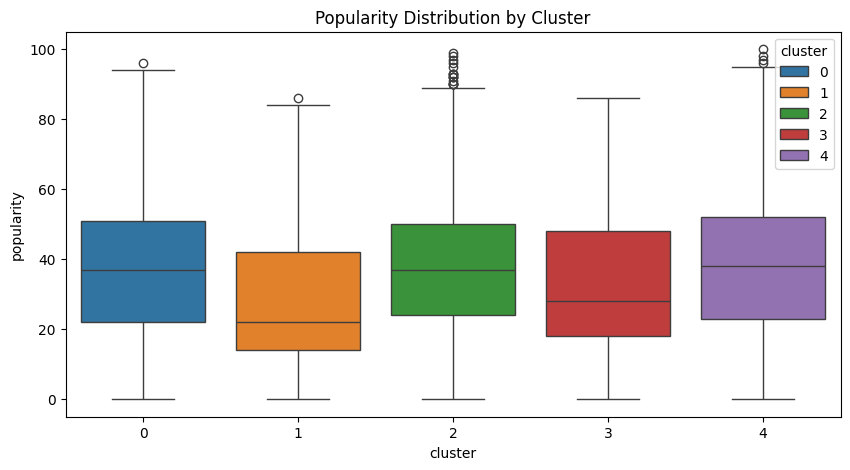

In [22]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_merged, x="cluster", y="popularity", hue="cluster")
plt.title("Popularity Distribution by Cluster")
plt.savefig(f"{IMAGE_DIR}/cluster_vs_popularity.png")
plt.show()

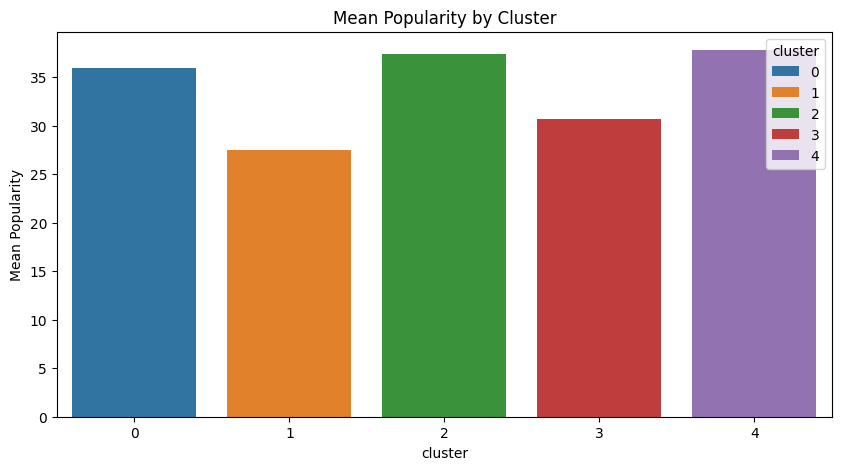

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=pop_summary,
    x="cluster",
    y="mean_popularity",
    errorbar=None,
    hue='cluster'
)
plt.title("Mean Popularity by Cluster")
plt.ylabel("Mean Popularity")
plt.savefig(f"{IMAGE_DIR}/mean_popularity_by_cluster.png")
plt.show()


In [24]:
features = feature_columns

cluster_profiles = (
    df_merged.groupby('cluster', observed=True)[features].mean()
)

scaler = MinMaxScaler()
cluster_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_profiles),
    index=cluster_profiles.index,
    columns=features
)

cluster_profiles_scaled

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,danceability_energy_index,acoustic_profile,mood_index,vocal_presence
cluster,,,,,,,,,,,,,
0,0.483879,0.281703,0.637957,0.105408,0.735576,0.002531,0.120445,0.328327,0.309498,0.262671,0.018484,0.190783,0.997469
1,0.628208,0.959283,0.832406,0.268631,0.000000,0.915483,0.225366,0.242623,0.862049,0.779283,0.097181,0.397196,0.084517
2,1.000000,0.968573,0.985661,0.485701,0.174358,0.000000,0.364041,1.000000,0.707639,1.000000,0.002017,1.000000,1.000000
3,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.403915,1.000000,1.000000,1.000000,0.054979,0.007435,1.000000,0.248211,1.000000,0.697688,0.000000,0.419373,0.992565


In [25]:
fig = go.Figure()

for cluster_id in cluster_profiles_scaled.index:
    fig.add_trace(
        go.Scatterpolar(
            r=cluster_profiles_scaled.loc[cluster_id].values,
            theta=features,
            fill="toself",
            name=f"Cluster {cluster_id}"
        )
    )

fig.update_layout(
    title="Audio Feature Profiles by Cluster",
    polar=dict(
        radialaxis=dict(visible=True, range=[0, 1])
    ),
    showlegend=True
)
fig.write_image(f"{PROJECT_ROOT}/figures/cluster_audio_profiles.png")
fig.show()


In [26]:
fig = px.violin(
    df_merged.sort_values("cluster"),
    x="cluster",
    y="popularity",
    box=True,
    points="outliers",
    title="Popularity Distribution by Music Cluster",
    labels={
        "cluster": "Cluster",
        "popularity": "Popularity Score"
    },
    color="cluster",
)

fig.update_layout(
    xaxis=dict(type="category"),
    yaxis=dict(title="Popularity"),
)
fig.write_image(f"{PROJECT_ROOT}/figures/violin_popularity_by_cluster.png")
fig.show()

In [27]:
pca_df = pd.DataFrame({
    "pc1": pca_result[:, 0],
    "pc2": pca_result[:, 1],
    "cluster": df_merged["cluster"].values,
    "popularity": df_merged["popularity"].values
}) # Create dataframe for PCA coordinates
pca_df.to_csv(MODELS_OUTPUT_PATH / "pca_coords.csv", index=False) # Save PCA coordinates

print("Saved PCA coordinates.")

Saved PCA coordinates.


In [28]:
sil_df = pd.DataFrame({
    "silhouette": silhouette_vals,
    "cluster": df_merged["cluster"].values
}) # Create dataframe for silhouette values
sil_df.to_csv(MODELS_OUTPUT_PATH / "silhouette_values.csv", index=False) # Save silhouette values

print("Saved silhouette values.")

Saved silhouette values.


In [29]:
df_merged.to_csv(
    MODELS_OUTPUT_PATH / "spotify_clustered.csv",
    index=False
)# Save clustered dataframe

print("Saved sample dataframe.")

Saved sample dataframe.


In [30]:
mw_popularity.to_csv(
    MODELS_OUTPUT_PATH / "mw_popularity_results.csv",
    index=False
)# Save Mann-Whitney U test results
print("Saved Mann-Whitney U test results.")

Saved Mann-Whitney U test results.


### 🧪 Hypothesis Decision

Null Hypothesis ($H_{0}$)

There are no statistically significant differences in popularity between the identified music clusters.

#### Decision

- Overall popularity differences (Kruskal–Wallis): ❌ Reject H₀

- Pairwise cluster comparisons (Mann–Whitney U, FDR-corrected): ❌ Reject H₀ for multiple clusters

So:

- Hypothesis 4 is supported.

🧠 Conclusion:

Hypothesis 4 is supported. The clustering analysis identified distinct musical profiles based on audio features, and these clusters exhibit statistically significant differences in track popularity. The Kruskal–Wallis test confirmed that popularity distributions vary across clusters, while post-hoc Mann–Whitney U tests showed that several clusters differ significantly from others even after controlling for multiple comparisons. Visual evidence from boxplots, violin plots, and cluster summaries further reinforces that popularity is systematically associated with specific combinations of musical characteristics. This indicates that track popularity is not randomly distributed, but is meaningfully influenced by underlying audio feature profiles.